In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from pathlib import Path

In [2]:
path = Path('/home/ec2-user/SageMaker/video_upscaling')
path_data = path/'data'/'DIV2K_train_HR'
path_lr = path/'data'/'lr'
path_mr = path/'data'/'mr'

In [3]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [4]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_data/x.name)
               .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
               .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    
    data.c = 3
    return data

In [5]:
data = get_data(bs, size)

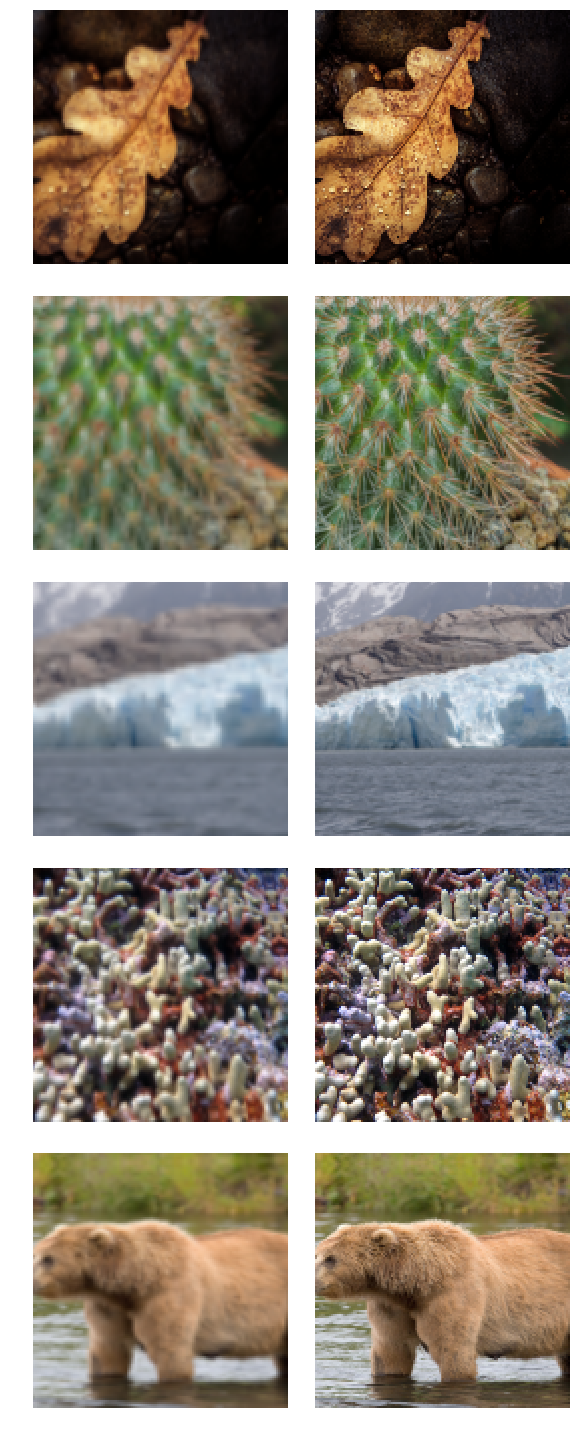

In [6]:
data.show_batch()

## Train

In [9]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=F.mse_loss,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,time
0,3.826612,#na#,01:05
1,2.672539,#na#,00:46
2,1.481772,#na#,00:47


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


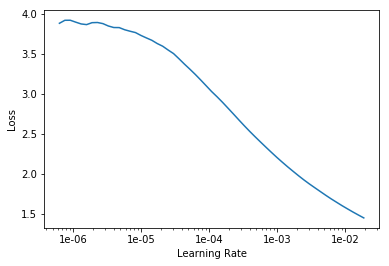

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
lr = 1e-3

In [12]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,time
0,0.510233,0.165881,01:19
1,0.275068,0.123252,00:53
2,0.186428,0.096285,00:53
3,0.138030,0.087182,00:52
4,0.109355,0.077933,00:52
5,0.093216,0.086108,00:53
6,0.089926,0.085522,00:52
7,0.081797,0.072177,00:53
8,0.074464,0.070497,00:53
9,0.069383,0.069408,00:53


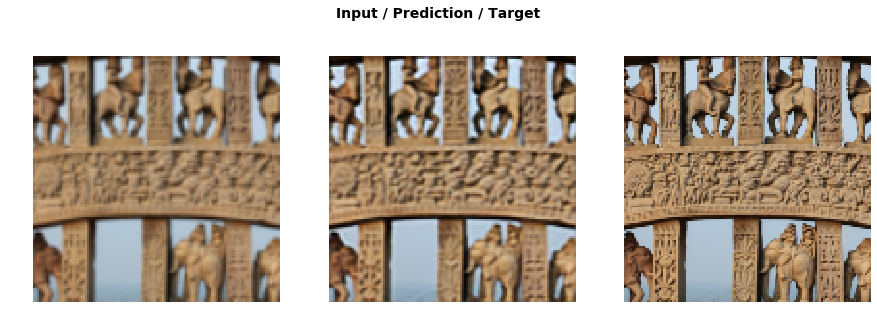

In [13]:
do_fit('unet-1a', slice(lr*10))

In [14]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.058906,0.069883,00:54
1,0.058326,0.069571,00:55
2,0.058639,0.068964,00:55
3,0.058689,0.068249,00:53
4,0.058571,0.069257,00:53
5,0.058242,0.068862,00:53
6,0.057857,0.067319,00:53
7,0.057843,0.070352,00:53
8,0.057553,0.069526,00:52
9,0.057135,0.065608,00:53


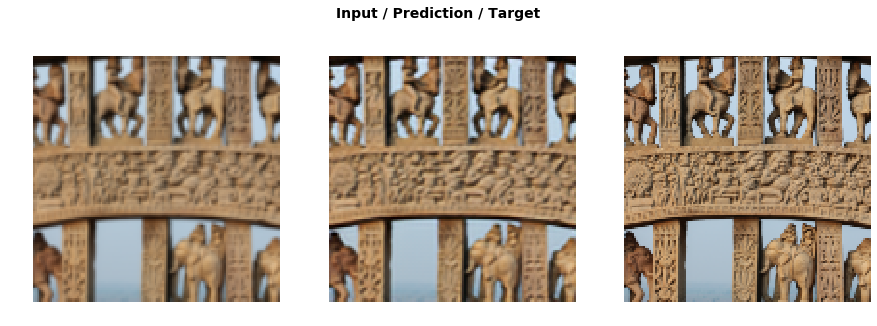

In [15]:
do_fit('unet-1b', slice(1e-5,lr))

In [16]:
data = get_data(12,size*2)

In [17]:
learn.data = data
learn.freeze()
gc.collect()

18568

In [18]:
learn.load('unet-1b');

epoch,train_loss,valid_loss,time
0,0.095589,0.089592,01:48
1,0.092014,0.088766,01:20
2,0.089029,0.087982,01:20
3,0.088617,0.087927,01:20
4,0.086466,0.087248,01:20
5,0.086550,0.089470,01:20
6,0.086160,0.088430,01:20
7,0.083896,0.084946,01:20
8,0.084270,0.086455,01:20
9,0.082846,0.083846,01:20


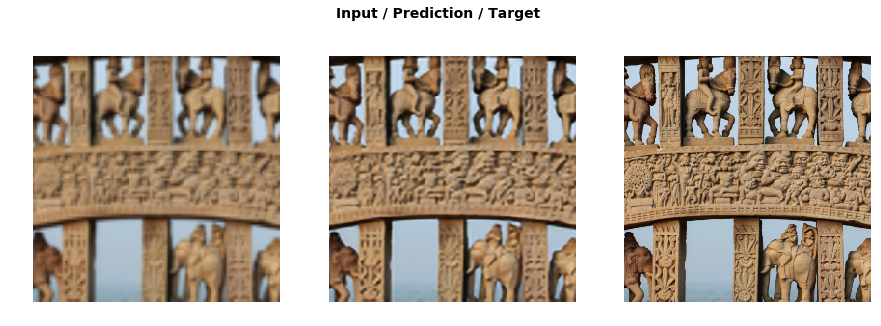

In [19]:
do_fit('unet-2a')

In [20]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,0.083273,0.083626,01:24
1,0.082035,0.083588,01:23
2,0.081736,0.083977,01:24
3,0.081512,0.084626,01:23
4,0.082937,0.083967,01:24
5,0.082465,0.083912,01:23
6,0.081233,0.083060,01:24
7,0.080910,0.084087,01:23
8,0.081829,0.083808,01:23
9,0.080323,0.083788,01:24


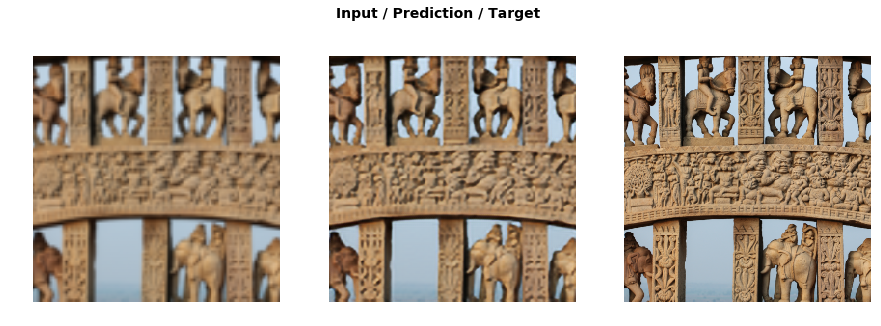

In [21]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [22]:
learn = None
gc.collect();

In [23]:
size = (128*4, 128*4)

In [24]:
learn = unet_learner(data, arch, loss_func=F.mse_loss, blur=True, norm_type=NormType.Weight)

In [25]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_data/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [27]:
learn.load('2b');

In [28]:
learn.data = data_mr

In [31]:
fn = data_mr.valid_ds.x.items[0]; fn

PosixPath('/home/ec2-user/SageMaker/video_upscaling/data/mr/0482.png')

In [32]:
img = open_image(fn); img.shape

torch.Size([3, 256, 350])

In [33]:
p,img_hr,b = learn.predict(img)

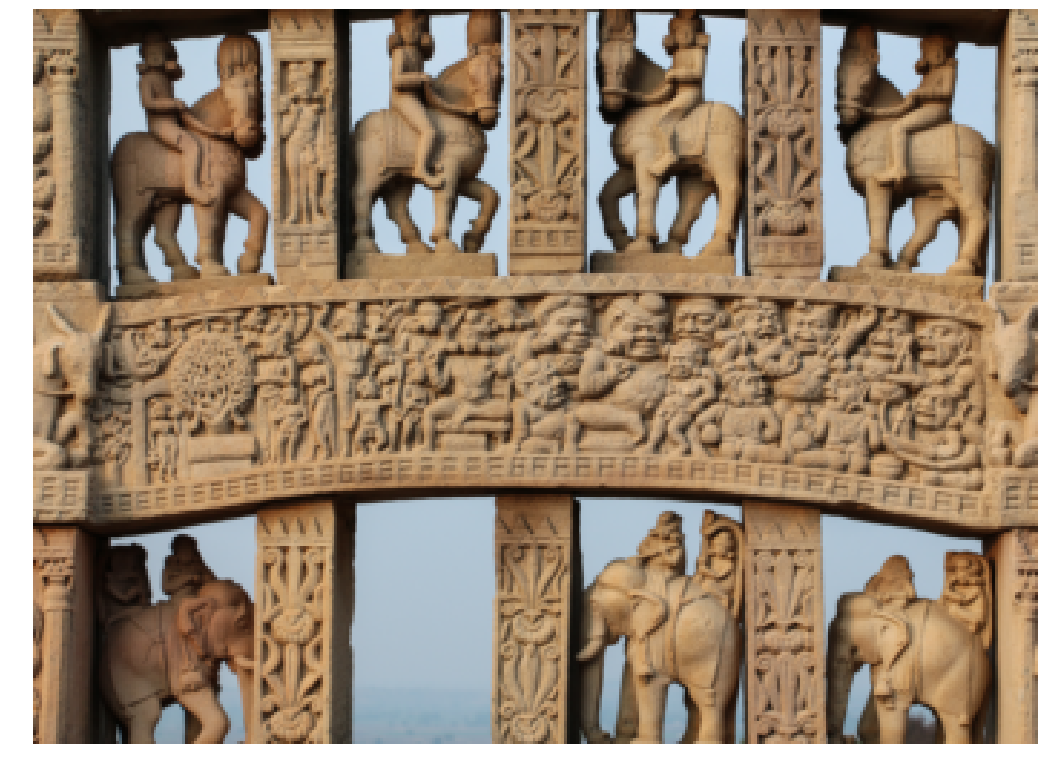

In [34]:
show_image(img, figsize=(18,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


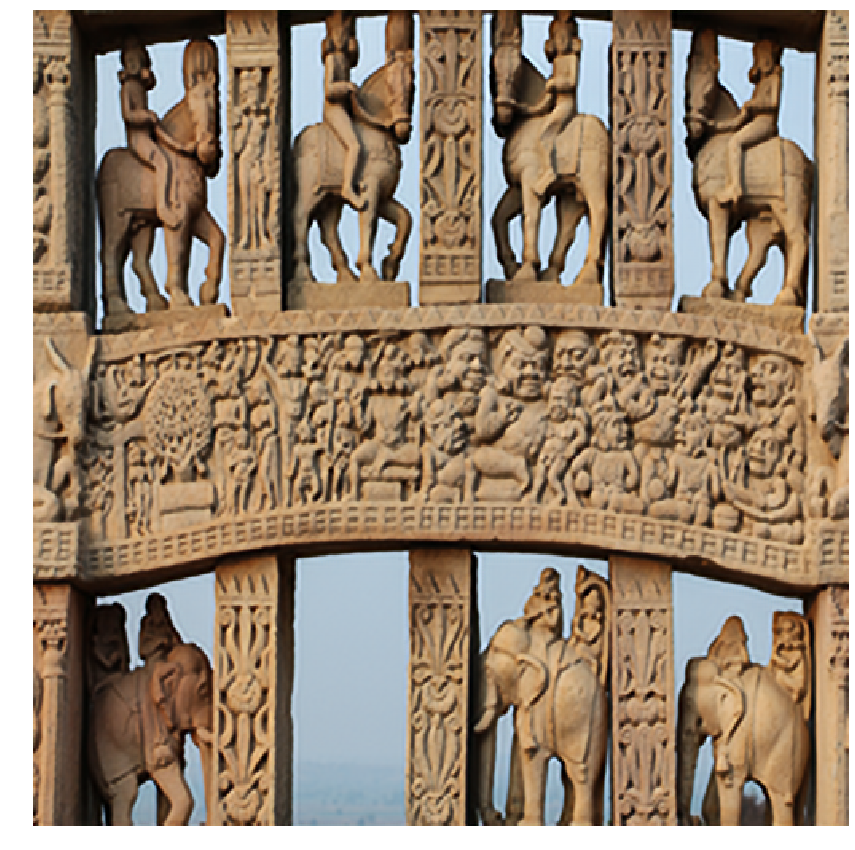

In [35]:
Image(img_hr).show(figsize=(18,15))